In [71]:
from __future__ import print_function

import pandas as pd
import numpy as np
import joblib as jl

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn import metrics
from sklearn.feature_selection import chi2
from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

root = 'naive_clf_assessment'

# Load data

In [72]:
labels = pd.read_csv('../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
print(labels.shape)
print(labels.head())

(11744, 1)
         CLASS
PIN           
568483       1
923748       0
2035328      0
2239386      1
2244533      1


In [73]:
data = pd.read_csv('../../tmp/raw_sequences.csv', header=0, index_col=0).loc[labels.index, 'seq']
data.head()

PIN
568483     10990 0 23 1 725 0 10990 0 10990 0 10990 0 109...
923748     66653 0 65070 0 66515 0 10962 0 105 0 56807 2 ...
2035328    66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...
2239386    10991 0 23 3 73928 0 66560 0 66515 0 66551 0 6...
2244533    10990 0 23 2 23 0 10990 0 73928 0 66500 0 6656...
Name: seq, dtype: object

In [104]:
D = 300
embedding = pd.read_csv('../../tmp/embedding.{}d.csv'.format(D), header=0, index_col=0)
embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1,-0.130043,0.034692,-0.006021,0.013212,0.001996,-0.042246,0.073535,-0.019646,-0.129925,-1.056039,...,-0.016195,-0.055285,-0.310134,-0.059643,0.070829,-0.004310,-0.071791,-0.104513,-0.013559,-0.025116
2,-0.130043,0.034692,-0.006021,0.013212,0.001996,-0.042246,0.073535,-0.019646,-0.129925,-1.056039,...,-0.016195,-0.055285,-0.310134,-0.059643,0.070829,-0.004310,-0.071791,-0.104513,-0.013559,-0.025116
3,-0.150065,0.102551,0.123458,0.003909,0.131512,0.014959,0.036136,0.016463,-0.146423,-1.268796,...,-0.036379,0.042793,-0.262882,-0.002599,0.145298,0.133144,-0.082144,-0.075551,0.101357,-0.149344
4,-0.201752,0.106557,0.092209,0.020688,0.051910,0.243464,0.157432,0.057078,-0.070607,-0.967402,...,-0.022403,-0.194310,-0.293100,-0.252164,0.110165,-0.050970,0.016583,-0.076823,-0.015480,-0.028163
57350,-0.215618,0.194823,0.074919,-0.067423,-0.035924,0.056523,0.002071,-0.027120,-0.071410,-1.115347,...,0.003674,-0.028858,-0.159660,-0.006941,0.054607,-0.002512,0.022903,-0.087150,-0.056744,-0.265652


# Prepare embedding dataset

In [107]:
# dfx_dump = {}
# dfx_dump[50] = dfX
# dfx_dump[100] = dfX
# dfx_dump[200] = dfX
# dfx_dump[300] = dfX

In [108]:
# jl.dump(dfx_dump, open('../../tmp/p.pkl', 'wb'))

In [105]:
X = []
for idx in tqdm(data.index):
    seq = map(int, data.loc[idx].split(' ')[::2])
    x_i = np.array([embedding.loc[i] for i in seq])
    X.append(np.sum(x_i, axis=0))
dfX = pd.DataFrame(data=np.array(X), index=data.index)

100%|██████████| 11744/11744 [06:25<00:00, 30.43it/s]


In [106]:
dfX.head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
PIN,,,,,,,,,,,,,,,,,,,,,
568483,-10.011440,18.750437,-5.405550,-21.975051,14.458817,-1.059816,0.442639,-5.696844,-2.568834,-148.646898,...,-19.947786,-11.338891,-16.105075,-6.234533,0.419577,18.398759,9.052148,-14.396454,8.509744,-20.241641
923748,-71.347171,24.115230,21.429641,-7.160646,33.534944,0.307389,17.269091,-4.831674,-34.249560,-395.254200,...,-12.590618,-29.992889,-57.644199,-33.893598,14.044567,12.966772,5.854945,-48.867030,15.003209,-36.974439


# Evaluate simple pipeline

In [121]:
pipe = Pipeline([
    ('clf', LogisticRegression())
    ])

In [110]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5)

cv_results_ = cross_validate(pipe, dfX, labels.values.ravel(), n_jobs=-1,
                             cv=sss, scoring=('accuracy', 'precision',
                                              'recall', 'f1', 'roc_auc'),
                             return_train_score=True
                            )

In [111]:
cv_results = pd.DataFrame(cv_results_).transpose()
cv_results.loc[:, 'MEAN'] = cv_results.mean(axis=1)
cv_results.loc[:, 'STD'] = cv_results.std(axis=1)
out = cv_results[['MEAN', 'STD']]
out

,MEAN,STD
fit_time,15.337961,2.815030
score_time,0.046393,0.009418
test_accuracy,0.692813,0.003350
test_f1,0.680525,0.002513
test_precision,0.708998,0.007019
test_recall,0.654360,0.006630
test_roc_auc,0.737446,0.003724
train_accuracy,0.731403,0.005364
train_f1,0.721715,0.004378
train_precision,0.748831,0.008089


In [113]:
out.to_csv(root+'/d{}_cv_results.csv'.format(D))

# Confusion matrix

In [114]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [115]:
y = labels.values.ravel()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
tr_idx, ts_idx = next(sss.split(np.empty_like(y), y))

x_train = dfX.iloc[tr_idx]
x_test = dfX.iloc[ts_idx]
y_train, y_test = y[tr_idx], y[ts_idx]
print(x_train.shape)

classifier = LogisticRegressionCV(n_jobs=-1)
y_pred = classifier.fit(x_train, y_train).predict(x_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

(5872, 300)


Test acc: 0.689
Test AUC: 0.689


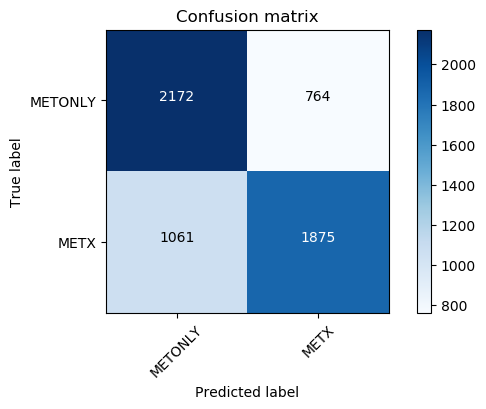

In [116]:
print('Test acc: {:2.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Test AUC: {:2.3f}'.format(metrics.roc_auc_score(y_test, y_pred)))

# Plot non-normalized confusion matrix
plt.figure(dpi=100)
plot_confusion_matrix(cnf_matrix, classes=['METONLY', 'METX'],
                      title='Confusion matrix', cmap=plt.cm.Blues)
plt.savefig(root+'/d{}-_cm.png'.format(D))

# Learning curves

In [117]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure(dpi=100)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("ROC AUC")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="C0")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="C1")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="C0",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'x-', color="C1",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    return plt

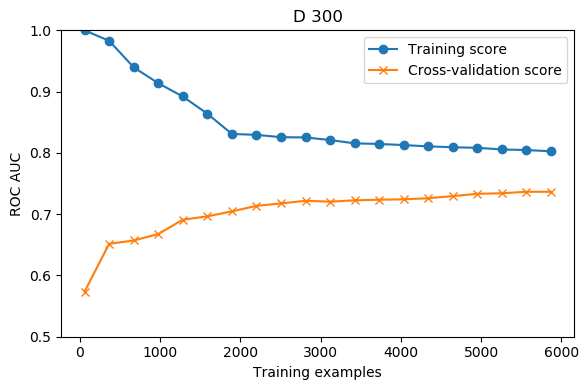

In [122]:
plot_learning_curve(pipe, 'D {}'.format(D),
                    dfX, labels.values.ravel(), cv=sss, ylim=[0.5, 1],
                    n_jobs=-1, train_sizes=np.linspace(0.01, 1, 20))
plt.savefig(root+'/d{}_lcurves.png'.format(D));

# Data viz

In [ ]:
pipe = Pipeline([
    ('dr1', TSNE(n_components=3, init='pca'))
    ])

x_r = pipe.fit_transform(dfX.values)

In [ ]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

idx = np.arange(x_r.shape[0])
np.random.shuffle(idx)
idx = idx[:600]

ax.scatter(x_r[idx, 0], x_r[idx, 1], x_r[idx, 2], c=y[idx])
plt.savefig(root+'/d{}_scatter.png'.format(D));